### Ejecutar comandos de dependencias

In [1]:
#%pip install -U tintolib

In [2]:
#%pip install -U torchmetrics pytorch_lightning TINTOlib imblearn keras_preprocessing mpi4py tifffile tqdm seaborn bitstring opencv-python pydot graphviz

In [3]:
#%pip install tensorflow[and-cuda] pandas numpy matplotlib scikit-learn seaborn notebook setuptools imbalanced-learn

Veamos si tenemos una GPU disponible para usar con CUDA

In [4]:
import tensorflow as tf
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))


2024-12-23 04:57:54.897607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734947874.970721   49504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734947874.992870   49504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 04:57:55.186866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Liberías

In [5]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error, f1_score, classification_report

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate, AveragePooling2D, Concatenate
from keras.utils import plot_model
#from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.barGraph import BarGraph
from TINTOlib.combination import Combination
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.supertml import SuperTML
from TINTOlib.tinto import TINTO
from TINTOlib.featureWrap import FeatureWrap
from TINTOlib.bie import BIE

# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 64
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Leemos el dataset y nos quedamos solo con nuestras variables relevantes

In [6]:
dataset_name = 'train'

#Read CSV
df = pd.read_csv(f"{dataset_name}.csv")
df = df.drop(columns=['ID','SKIN_CANCER', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH', 'TABACCO_PRODUCTS', 'HEAVY_DRINKERS','E_CIGARETTES', 'FRIED_POTATOES','FRUITS','VEGETABLES'])
df.head(2)

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY
0,1.0,1,34,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3421.0,2.0,2.0,2.0,1
1,0.0,1,76,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2.0,1.0,2.0,2870.0,2.0,1.0,NaN,1


Analizemos los valores nulos

In [9]:
# Analizamos los valores nulos
missing_columns = df.isnull().sum().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns > 0]
print("Cantidad de valores nulos por columna")
print(missing_columns)


non_missing_columns = df.columns[~df.isnull().any()]
print("Columnas sin valores nulos")
print(non_missing_columns, non_missing_columns.shape)

Cantidad de valores nulos por columna
HIGH_CHOLESTEROL       50191
HIV                    40794
BMI                    36960
SMOKE                  19263
DIFFICULTY_WALKING     15604
ARTHRITIS               1954
DEPRESSIVE_DISORDER     1686
BRONCHITIS              1313
BLOOD_PRESSURE          1307
KIDNEY_DISEASE          1131
HEALTH                   838
CANCER                   792
PHYSICAL_ACTIVITIES      653
DIABETES                 530
dtype: int64
Columnas sin valores nulos
Index(['CHD_OR_MI', 'SEX', 'AGE', 'ETHNICITY'], dtype='object') (4,)


Ahora analicemos los valores de cada columna

In [10]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Valores únicos en la columna '{column}': {unique_values}\n")

Valores únicos en la columna 'CHD_OR_MI': [1. 0.]

Valores únicos en la columna 'SEX': [1 2]

Valores únicos en la columna 'AGE': [34 76 69 36 21 44 43 56 72 80 26 68 63 74 70 78 40 30 64 28 62 22 25 52
 65 41 75 20 46 77 29 57 55 59 27 23 48 33 67 60 37 71 51 54 53 32 73 35
 39 49 79 61 66 58 50 42 31 24 38 19 18 45 47]

Valores únicos en la columna 'HEALTH': [ 1.  2. nan]

Valores únicos en la columna 'PHYSICAL_ACTIVITIES': [ 1.  2. nan]

Valores únicos en la columna 'BLOOD_PRESSURE': [ 1.  2. nan]

Valores únicos en la columna 'HIGH_CHOLESTEROL': [ 2.  1. nan]

Valores únicos en la columna 'CANCER': [ 2.  1. nan]

Valores únicos en la columna 'BRONCHITIS': [ 2.  1. nan]

Valores únicos en la columna 'DEPRESSIVE_DISORDER': [ 2. nan  1.]

Valores únicos en la columna 'KIDNEY_DISEASE': [ 2. nan  1.]

Valores únicos en la columna 'DIABETES': [ 3.  1.  4.  2. nan]

Valores únicos en la columna 'ARTHRITIS': [ 2.  1. nan]

Valores únicos en la columna 'BMI': [3421. 2870.   nan ... 5646. 15

Vamos a quedarnos unicamente con las columnas que indican riesgo en enfermedades coronarias basados en investigaciones científicas, luego poco a poco, iremos agregando más columnas, para ver si el desempeño mejora o no

In [11]:
for column in missing_columns.index:
    if column == 'BMI':
        df[column] = df[column].fillna(df[column].mean())
    else:
        df[column] = df[column].fillna(df[column].mode()[0])


Creamos 5 datasets con la clase de menor cantidad

In [ ]:
# Separamos las clases
class_0 = df[df['CHD_OR_MI'] == 0.0]
class_1 = df[df['CHD_OR_MI'] == 1.0]

# Creamos 5 datasets
from sklearn.utils import resample

balanced_datasets = []
n_samples_class_1 = len(class_0) 

for i in range(5):
    sampled_class_1 = resample(class_1, 
                               replace=False,  
                               n_samples=n_samples_class_1, 
                               random_state=i) 
    balanced_dataset = pd.concat([class_0, sampled_class_1])
    balanced_datasets.append(balanced_dataset)

balanced_datasets[1]

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY
1,0.0,1,76,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2870.000000,2.0,1.0,2.0,1
18,0.0,1,78,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,3587.000000,1.0,1.0,2.0,1
23,0.0,1,69,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2855.145811,2.0,1.0,2.0,2
39,0.0,1,75,1.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,2.0,3132.000000,2.0,1.0,2.0,1
44,0.0,1,77,2.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2741.000000,1.0,1.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301807,1.0,1,52,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,1.0,2726.000000,1.0,2.0,2.0,1
101471,1.0,1,64,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3417.000000,1.0,2.0,2.0,1
74277,1.0,2,22,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2163.000000,2.0,2.0,1.0,1
221425,1.0,2,52,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2098.000000,2.0,2.0,1.0,5


Cambiamos de posición a la columna `CHD_OR_MI`, para que se tome encuenta esta variable al momento de crear nuestras imágenes sintéticas.

In [ ]:
df = balanced_datasets[0]


col_data = df.pop("CHD_OR_MI")  # Quitamos la columna del DataFrame y la guarda
df.insert(len(df.columns), "CHD_OR_MI", col_data)  # Insertamos al final
# Mezclamos las filas y resetear el índice
df= df.sample(frac=1, random_state=42).reset_index(drop=True)


df.head(2)


,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,CHD_OR_MI
0,1,67,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,2772.0,2.0,2.0,2.0,1,1.0
1,2,52,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2510.0,2.0,2.0,2.0,1,1.0


In [14]:
df["CHD_OR_MI"].value_counts()

CHD_OR_MI
1.0    28258
0.0    28258
Name: count, dtype: int64

In [15]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Valores únicos en la columna '{column}': {unique_values}\n")

Valores únicos en la columna 'SEX': [1 2]

Valores únicos en la columna 'AGE': [67 52 33 74 69 71 53 48 34 80 77 45 65 64 63 76 75 72 38 73 60 27 41 32
 56 68 70 30 29 58 43 62 59 22 25 26 46 20 31 54 55 36 78 39 18 47 37 21
 51 61 66 40 50 42 79 19 57 35 24 49 28 44 23]

Valores únicos en la columna 'HEALTH': [1. 2.]

Valores únicos en la columna 'PHYSICAL_ACTIVITIES': [1. 2.]

Valores únicos en la columna 'BLOOD_PRESSURE': [2. 1.]

Valores únicos en la columna 'HIGH_CHOLESTEROL': [2. 1.]

Valores únicos en la columna 'CANCER': [2. 1.]

Valores únicos en la columna 'BRONCHITIS': [2. 1.]

Valores únicos en la columna 'DEPRESSIVE_DISORDER': [2. 1.]

Valores únicos en la columna 'KIDNEY_DISEASE': [2. 1.]

Valores únicos en la columna 'DIABETES': [3. 1. 2. 4.]

Valores únicos en la columna 'ARTHRITIS': [1. 2.]

Valores únicos en la columna 'BMI': [2772. 2510. 2511. ... 5384. 1427. 4900.]

Valores únicos en la columna 'DIFFICULTY_WALKING': [2. 1.]

Valores únicos en la columna 'SMOKE': [2.

Calculemos el tamaño de nuestra imagen calculando la raiz cuadrada de la cantidad de nuestras caracteristicas

In [16]:
num_columns = df.shape[1]

columns_minus_one = num_columns - 1

import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

5


Definimos el tipo de problema y nuestra clase TINTO que se encargará de transformar sintéticamente nuestros datos tabulares a imágenes

In [ ]:
problem_type = "supervised"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"


# Definimos en que carpeta se guardarán nuesras imagenes 
results_folder = f"{dataset_name}_{name}"
images_folder = f"{dataset_name}_{name}"

Generamos las imagenes

In [ ]:
import os

if not os.path.exists(images_folder):
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

train_TINTO_blur_maximum/supervised.csv


Leemos el dataset generados con la referencia de nuestras imágenes sintéticas a nuestros datos tabulares, para posteriormente juntarlos

In [ ]:
imgs = pd.read_csv(img_paths) 

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]
imgs.head(2)

,images,class
0,train_TINTO_blur_maximum/01/000000.png,1.0
1,train_TINTO_blur_maximum/01/000001.png,1.0


In [20]:
df["images"] = imgs["images"]
df

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,CHD_OR_MI,images
0,1,67,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,2772.0,2.0,2.0,2.0,1,1.0,train_TINTO_blur_maximum/01/000000.png
1,2,52,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2510.0,2.0,2.0,2.0,1,1.0,train_TINTO_blur_maximum/01/000001.png
2,1,33,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2511.0,2.0,1.0,1.0,1,1.0,train_TINTO_blur_maximum/01/000002.png
3,1,74,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2905.0,2.0,1.0,2.0,1,0.0,train_TINTO_blur_maximum/00/000003.png
4,1,69,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,3.0,2.0,2399.0,2.0,1.0,2.0,1,0.0,train_TINTO_blur_maximum/00/000004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56511,1,80,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2737.0,2.0,2.0,2.0,1,1.0,train_TINTO_blur_maximum/01/056511.png
56512,2,61,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,3433.0,2.0,2.0,2.0,1,1.0,train_TINTO_blur_maximum/01/056512.png
56513,2,73,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3779.0,1.0,2.0,2.0,1,0.0,train_TINTO_blur_maximum/00/056513.png
56514,1,80,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,2663.0,2.0,2.0,1.0,1,0.0,train_TINTO_blur_maximum/00/056514.png


In [ ]:


df_x = df.drop(columns=["CHD_OR_MI"])
df_y = df["CHD_OR_MI"]

print(df_y)

0        1.0
1        1.0
2        1.0
3        0.0
4        0.0
        ... 
56511    1.0
56512    1.0
56513    0.0
56514    0.0
56515    1.0
Name: CHD_OR_MI, Length: 56516, dtype: float64


In [22]:
df_x

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,images
0,1,67,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,2772.0,2.0,2.0,2.0,1,train_TINTO_blur_maximum/01/000000.png
1,2,52,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2510.0,2.0,2.0,2.0,1,train_TINTO_blur_maximum/01/000001.png
2,1,33,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2511.0,2.0,1.0,1.0,1,train_TINTO_blur_maximum/01/000002.png
3,1,74,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,2905.0,2.0,1.0,2.0,1,train_TINTO_blur_maximum/00/000003.png
4,1,69,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,3.0,2.0,2399.0,2.0,1.0,2.0,1,train_TINTO_blur_maximum/00/000004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56511,1,80,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2737.0,2.0,2.0,2.0,1,train_TINTO_blur_maximum/01/056511.png
56512,2,61,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,3433.0,2.0,2.0,2.0,1,train_TINTO_blur_maximum/01/056512.png
56513,2,73,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,3779.0,1.0,2.0,2.0,1,train_TINTO_blur_maximum/00/056513.png
56514,1,80,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,2663.0,2.0,2.0,1.0,1,train_TINTO_blur_maximum/00/056514.png


Generamos la data para entrenamiento, validación en el momento de entrenamiento para evitar overfitting y tests.

In [23]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.20, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=SEED)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
#X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
#X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
#X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Scale numerical data
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

attributes = X_train_num.shape[1]
height, width = X_train_img[0].shape
channels = 1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixel=X_train_img[0].shape[0]
print("Image size (pixels):", pixel)

Images shape:  (20, 20, 1)
Attributres:  17
Image size (pixels): 20


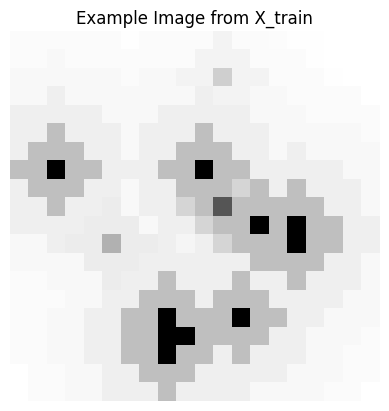

In [24]:
# Plot an example image (e.g., the first image in the array)
example_image = X_train_img[8]

# Convert the image from BGR (OpenCV default) to RGB for correct color display
example_image_rgb = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.imshow(example_image_rgb)
plt.title("Example Image from X_train")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

### Implementación de arquitectura

Llegó el momento de implementar nuestra arquiectura


![](img/image.png)

Comenzamos con los dos perceptrón multicapa de la zona inferior

In [25]:
dropout = 0.1

In [26]:
# Two branch FFNN

ff_inputs = Input(shape = (attributes,))

# * START BRANCH 1
mlp_1 = Dense(1024, activation='relu')(ff_inputs)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(512, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(256, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(128, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(64, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(32, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

mlp_1 = Dense(16, activation='relu')(mlp_1)
mlp_1 = BatchNormalization()(mlp_1)
mlp_1 = Dropout(dropout)(mlp_1)

# * START BRANCH 2
mlp_2 = Dense(1024, activation='relu')(ff_inputs)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(512, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(256, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(128, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(64, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(32, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

mlp_2 = Dense(16, activation='relu')(mlp_2)
mlp_2 = BatchNormalization()(mlp_2)
mlp_2 = Dropout(dropout)(mlp_2)

merged_tabular = Concatenate(axis=1)([mlp_1, mlp_2])

ff_model = Model(inputs = ff_inputs, outputs = merged_tabular)

I0000 00:00:1734947925.323454   49504 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Continuamos con nuestras dos redes neuronales convolucionales y como se concatenan con un MLP.

In [27]:
#Input
input_shape = Input(shape=imgs_shape)

# CNN branch 1
tower_1 = Conv2D(16, (3,3), activation='relu',padding="same")(input_shape)
tower_1 = BatchNormalization()(tower_1)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)

tower_1 = Conv2D(32, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = BatchNormalization()(tower_1)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)

tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = BatchNormalization()(tower_1)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)

tower_1 = Conv2D(64, (3,3), activation='relu',padding="same")(tower_1)
tower_1 = BatchNormalization()(tower_1)
tower_1 = Activation('relu')(tower_1)
tower_1 = MaxPooling2D(2,2)(tower_1)
tower_1 = Dropout(dropout)(tower_1)

#CNN branch 2
tower_2 = Conv2D(16, (5,5), activation='relu',padding="same")(input_shape)
tower_2 = BatchNormalization()(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)

tower_2 = Conv2D(32, (5,5), activation='relu',padding="same")(tower_2)
tower_2 = BatchNormalization()(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)

tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
tower_2 = BatchNormalization()(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)

tower_2 = Conv2D(64, (5,5), activation='relu',padding="same")(tower_2)
tower_2 = BatchNormalization()(tower_2)
tower_2 = Activation('relu')(tower_2)
tower_2 = AveragePooling2D(2,2)(tower_2)
tower_2 = Dropout(dropout)(tower_2)

#Concatenate CNN branches
merged = Concatenate(axis=1)([tower_1, tower_2])

#Flatten
merged = Flatten()(merged)

#Dense layers
out = Dense(512, activation='relu')(merged)
out = Dropout(dropout)(merged)
out = Dense(256, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(128, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(64, activation='relu')(out)
out = Dropout(dropout)(out)
out = Dense(32, activation='relu')(out)
out = Dropout(dropout)(out)

cnn_model = Model(input_shape, out)

Finalmente concatenamos nuestros dos modelos en un MLP com función de activación sigmoide 

In [28]:
combinedInput = concatenate([ff_model.output, cnn_model.output])
x = Dense(64, activation="relu")(combinedInput)
x = Dense(32, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[ff_model.input, cnn_model.input], outputs=x)

In [29]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

In [30]:
os.makedirs(results_folder, exist_ok=True)

# Redirect the summary output to the specified file
with open(results_folder+"/model_summary.txt", "w") as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Desactivar la visualización automática de matplotlib
plt.ioff()
# Now, you can also save the model plot
plot_model(model, to_file=results_folder+'model_plot.png', show_shapes=True, expand_nested=True)
# Reactivar la visualización automática de matplotlib (opcional)
plt.ion()

Usamos como optimizar al algoritmo de descenso Adam

In [31]:
opt = Adam(learning_rate=1e-3)

Compilamos y entrenamos a nuestro modelo

In [32]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [33]:
# Configure EarlyStopping for binary classification
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation accuracy
    min_delta=0.001,         # Minimum change in the monitored quantity to qualify as an improvement
    patience=20,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Log when training stops
    mode='min',              # Maximize the accuracy; min the loss
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [34]:
model_history=model.fit(
    x=[X_train_num, X_train_img], y=y_train,
    validation_data=([X_val_num, X_val_img], y_val),
    epochs=200,
    batch_size=32,
    callbacks = [early_stopper]
)

Epoch 1/200


I0000 00:00:1734947938.893481   49980 service.cc:148] XLA service 0x7f46c4002430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734947938.893599   49980 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-23 04:58:59.233548: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734947940.708493   49980 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-23 04:59:03.206886: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  16/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.2549 - mae: 0.4615 - mse: 0.2549 - r_square: -0.0538 - rmse: 0.5039      

I0000 00:00:1734947954.753512   49980 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - loss: 0.1757 - mae: 0.3391 - mse: 0.1757 - r_square: 0.2697 - rmse: 0.4190 - val_loss: 0.1586 - val_mae: 0.3066 - val_mse: 0.1586 - val_r_square: 0.3412 - val_rmse: 0.3983
Epoch 2/200
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.1649 - mae: 0.3244 - mse: 0.1649 - r_square: 0.3146 - rmse: 0.4061 - val_loss: 0.1581 - val_mae: 0.3087 - val_mse: 0.1581 - val_r_square: 0.3433 - val_rmse: 0.3976
Epoch 3/200
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1637 - mae: 0.3237 - mse: 0.1637 - r_square: 0.3198 - rmse: 0.4046 - val_loss: 0.1577 - val_mae: 0.3081 - val_mse: 0.1577 - val_r_square: 0.3447 - val_rmse: 0.3971
Epoch 4/200
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1632 - mae: 0.3228 - mse: 0.1632 - r_square: 0.3219 - rmse: 0.4040 - val_loss: 0.1571 - val_mae: 0.3071 - val_mse: 0.1571 - val_r_square: 0.3476 - val_rmse: 0.3963
Epoch 5/200
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1625 - mae: 0.3223 - mse: 0

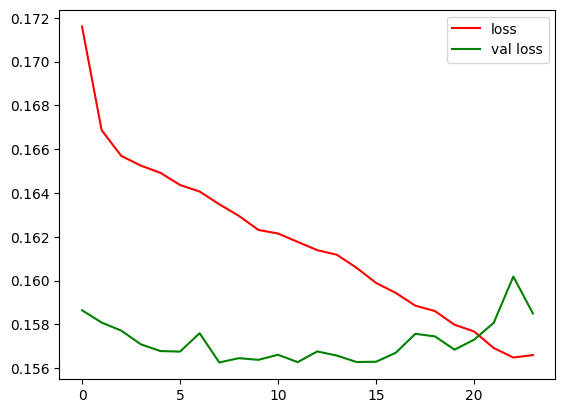

In [35]:
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

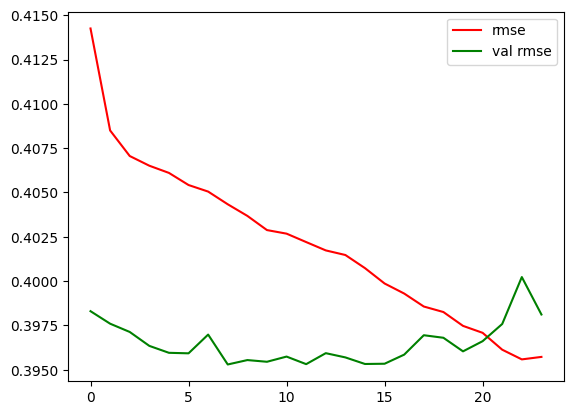

In [36]:
plt.plot(model_history.history['rmse'], color = 'red', label = 'rmse')
plt.plot(model_history.history['val_rmse'], color = 'green', label = 'val rmse')
plt.legend(loc = 'upper right')
plt.show()

In [37]:
prediction = model.predict([X_test_num,X_test_img])

test_mape = mean_absolute_percentage_error(y_test, prediction)
test_mae = mean_absolute_error(y_test, prediction)
test_mse = mean_squared_error(y_test, prediction)
test_rmse = mean_squared_error(y_test, prediction,)
test_r2 = r2_score(y_test, prediction)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("R2 Score:", test_r2)

# Define the metrics and their values
metrics = {
    "Mean Absolute Percentage Error": test_mape,
    "Mean Absolute Error": test_mae,
    "Mean Squared Error": test_mse,
    "Root Mean Squared Error": test_rmse,
    "R2 Score": test_r2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics.txt", "w") as file:
    for metric, value in metrics.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics.txt")

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 
Mean Absolute Percentage Error: 772268330653813.4
Mean Absolute Error: 0.3137742444620417
Mean Squared Error: 0.16268484601026395
Root Mean Squared Error: 0.16268484601026395
R2 Score: 0.3492507564626699
Metrics saved to train_TINTO_blur_maximum/metrics.txt


In [38]:
y_train.shape

(45212,)

Nuestros resultados finales son los siguientes:

In [39]:
prediction = (prediction > 0.5).astype(int)
print(f'F1-score: {f1_score(y_test,prediction)}')
print(classification_report(y_test,prediction))

F1-score: 0.7562782294489612
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77      2837
         1.0       0.77      0.74      0.76      2815

    accuracy                           0.76      5652
   macro avg       0.76      0.76      0.76      5652
weighted avg       0.76      0.76      0.76      5652



In [40]:
# TESTING

Probamos con test_public.csv, por lo que tenemos que realiza el mismo tratamiento de datos lo que involucra generar nuestras imágenes sintéticas

In [41]:
test_dataset_name = 'test_public'

#Read CSV
test_df = pd.read_csv(f"{test_dataset_name}.csv")
id_df = test_df['ID']
test_df = test_df.drop(columns=['ID','SKIN_CANCER', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH', 'TABACCO_PRODUCTS', 'HEAVY_DRINKERS','E_CIGARETTES', 'FRIED_POTATOES', 'FRUITS','VEGETABLES'])
test_df.head(2)

,CHD_OR_MI,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY
0,1.0,2,70,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2130.0,2.0,1.0,2.0,1
1,1.0,1,32,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2439.0,2.0,1.0,1.0,1


In [42]:
test_df["CHD_OR_MI"].value_counts()

CHD_OR_MI
1.0    39874
0.0     3532
Name: count, dtype: int64

In [43]:
missing_columns = test_df.isnull().sum().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns > 0]
for column in missing_columns.index:
    test_df[column].fillna(test_df[column].mode()[0], inplace=True)


/tmp/ipykernel_49504/3026782114.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[column].fillna(test_df[column].mode()[0], inplace=True)


In [44]:
col_data = test_df.pop("CHD_OR_MI")  # Quita la columna del DataFrame y la guarda
test_df.insert(len(test_df.columns), "CHD_OR_MI", col_data)  # Inserta al final

# Mezclar las filas y resetear el índice
test_df= test_df.reset_index(drop=True)

In [45]:
test_df

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,CHD_OR_MI
0,2,70,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2130.0,2.0,1.0,2.0,1,1.0
1,1,32,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2439.0,2.0,1.0,1.0,1,1.0
2,1,69,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3138.0,2.0,2.0,2.0,1,1.0
3,1,36,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,3027.0,2.0,2.0,1.0,2,1.0
4,1,63,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,2720.0,2.0,2.0,2.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,1,69,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,4991.0,2.0,2.0,1.0,6,0.0
43402,2,57,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2663.0,2.0,2.0,2.0,1,1.0
43403,1,75,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,3396.0,2.0,2.0,2.0,5,0.0
43404,2,50,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,2281.0,2.0,1.0,1.0,1,1.0


In [46]:
num_columns = test_df.shape[1]

columns_minus_one = num_columns - 1

import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

5


In [47]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
results_folder = f"{test_dataset_name}_{name}"
images_folder = f"{test_dataset_name}_{name}"

In [48]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(test_df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

test_public_TINTO_blur_maximum/supervised.csv


In [49]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]
imgs.head(2)

,images,class
0,test_public_TINTO_blur_maximum/01/000000.png,1.0
1,test_public_TINTO_blur_maximum/01/000001.png,1.0


In [50]:
test_df["images"] = imgs["images"]
test_df

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,CHD_OR_MI,images
0,2,70,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2130.0,2.0,1.0,2.0,1,1.0,test_public_TINTO_blur_maximum/01/000000.png
1,1,32,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2439.0,2.0,1.0,1.0,1,1.0,test_public_TINTO_blur_maximum/01/000001.png
2,1,69,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3138.0,2.0,2.0,2.0,1,1.0,test_public_TINTO_blur_maximum/01/000002.png
3,1,36,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,3027.0,2.0,2.0,1.0,2,1.0,test_public_TINTO_blur_maximum/01/000003.png
4,1,63,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,2.0,2720.0,2.0,2.0,2.0,1,1.0,test_public_TINTO_blur_maximum/01/000004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,1,69,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,4991.0,2.0,2.0,1.0,6,0.0,test_public_TINTO_blur_maximum/00/043401.png
43402,2,57,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2663.0,2.0,2.0,2.0,1,1.0,test_public_TINTO_blur_maximum/01/043402.png
43403,1,75,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,3396.0,2.0,2.0,2.0,5,0.0,test_public_TINTO_blur_maximum/00/043403.png
43404,2,50,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,2281.0,2.0,1.0,1.0,1,1.0,test_public_TINTO_blur_maximum/01/043404.png


In [51]:
test_df["CHD_OR_MI"].value_counts()

CHD_OR_MI
1.0    39874
0.0     3532
Name: count, dtype: int64

In [52]:
# Drop target column and values which is a copy of target column


test_df_x = test_df.drop(columns=["CHD_OR_MI"])
test_df_y = test_df["CHD_OR_MI"]

print(test_df_y)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
43401    0.0
43402    1.0
43403    0.0
43404    1.0
43405    1.0
Name: CHD_OR_MI, Length: 43406, dtype: float64


In [53]:
from sklearn.preprocessing import MinMaxScaler

#TIDY DATA SPLITTED
X_test_num_df = test_df_x.drop("images",axis=1)

#IMAGES
# For 3 channels (RGB)
#X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
#X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
#X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
X_test_img_df = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in test_df_x["images"]])


# Scale numerical data
X_test_num_df = scaler.transform(X_test_num_df)

attributes = X_test_num_df.shape[1]
height, width = X_test_img_df[0].shape
channels = 1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)

Images shape:  (20, 20, 1)
Attributres:  17


In [54]:
prediction = model.predict([X_test_num_df,X_test_img_df])

test_mape = mean_absolute_percentage_error(test_df_y, prediction)
test_mae = mean_absolute_error(test_df_y, prediction)
test_mse = mean_squared_error(test_df_y, prediction)
test_rmse = mean_squared_error(test_df_y, prediction,)
test_r2 = r2_score(test_df_y, prediction)

# Print the evaluation metrics
print("Mean Absolute Percentage Error:", test_mape)
print("Mean Absolute Error:", test_mae)
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("R2 Score:", test_r2)

# Define the metrics and their values
metrics = {
    "Mean Absolute Percentage Error": test_mape,
    "Mean Absolute Error": test_mae,
    "Mean Squared Error": test_mse,
    "Root Mean Squared Error": test_rmse,
    "R2 Score": test_r2,
}

# Save the metrics to a text file
with open(f"{results_folder}/metrics.txt", "w") as file:
    for metric, value in metrics.items():
        file.write(f"{metric}: {value}\n")

print(f"Metrics saved to {results_folder}/metrics.txt")

1357/1357 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Mean Absolute Percentage Error: 126745839307622.78
Mean Absolute Error: 0.28980617763086913
Mean Squared Error: 0.15743998226938527
Root Mean Squared Error: 0.15743998226938527
R2 Score: -1.1062216126177455
Metrics saved to test_public_TINTO_blur_maximum/metrics.txt


Obteniendo este valor en nuestro reporte

In [55]:
prediction = (prediction > 0.5).astype(int)
print(f'F1-score: {f1_score(test_df_y,prediction)}')
print(classification_report(test_df_y,prediction))

F1-score: 0.8472997083061935
              precision    recall  f1-score   support

         0.0       0.21      0.77      0.33      3532
         1.0       0.97      0.75      0.85     39874

    accuracy                           0.75     43406
   macro avg       0.59      0.76      0.59     43406
weighted avg       0.91      0.75      0.81     43406



In [56]:
prediction[:,0]

array([0, 1, 0, ..., 0, 1, 1])

In [57]:
result_df = pd.DataFrame({'ID':id_df, 'CHD_OR_MI':prediction[:,0]})
result_df

,ID,CHD_OR_MI
0,PID2022_100531,0
1,PID2022_043184,1
2,PID2022_071971,0
3,PID2022_070778,1
4,PID2022_082363,0
...,...,...
43401,PID2022_256399,0
43402,PID2022_326390,1
43403,PID2022_178405,0
43404,PID2022_220522,1


Ahora hagamos predict de nuestra data para submisión

In [58]:
test_dataset_name_p = 'test_private'

#Read CSV
test_df_p = pd.read_csv(f"{test_dataset_name_p}.csv")
id_df_p = test_df_p['ID']
test_df_p = test_df_p.drop(columns=['ID','SKIN_CANCER', 'PHYSICAL_HEALTH', 'MENTAL_HEALTH', 'TABACCO_PRODUCTS', 'HEAVY_DRINKERS','E_CIGARETTES', 'FRIED_POTATOES', 'FRUITS','VEGETABLES'])
test_df_p.head(2)

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY
0,2,56,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,3061.0,1.0,1.0,1.0,1
1,2,59,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1716.0,2.0,2.0,2.0,1


In [59]:
missing_columns = test_df_p.isnull().sum().sort_values(ascending=False)
missing_columns = missing_columns[missing_columns > 0]
for column in missing_columns.index:
    test_df_p[column].fillna(test_df_p[column].mode()[0], inplace=True)


/tmp/ipykernel_49504/2961659846.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df_p[column].fillna(test_df_p[column].mode()[0], inplace=True)


In [60]:
# Resetear el índice
test_df_p= test_df_p.reset_index(drop=True)

In [61]:
num_columns = test_df_p.shape[1]

columns_minus_one = num_columns - 1

import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [62]:
#Select the model and the parameters
problem_type = "supervised"
#problem_type = "regression"

# Transformation methods
image_model = TINTO(problem=problem_type, blur=True, option='maximum', pixels=20, random_seed=SEED)
name = f"TINTO_blur_maximum"

#Define the dataset path and the folder where the images will be saved
results_folder = f"{test_dataset_name_p}_{name}"
images_folder = f"{test_dataset_name_p}_{name}"

In [64]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(test_df_p, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

test_private_TINTO_blur_maximum/supervised.csv


In [65]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]
imgs.head(2)

,images,class
0,test_private_TINTO_blur_maximum/01/000000.png,1
1,test_private_TINTO_blur_maximum/01/000001.png,1


In [66]:
test_df_p["images"] = imgs["images"]
test_df_p

,SEX,AGE,HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,CANCER,BRONCHITIS,DEPRESSIVE_DISORDER,KIDNEY_DISEASE,DIABETES,ARTHRITIS,BMI,DIFFICULTY_WALKING,SMOKE,HIV,ETHNICITY,images
0,2,56,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,3061.0,1.0,1.0,1.0,1,test_private_TINTO_blur_maximum/01/000000.png
1,2,59,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,1716.0,2.0,2.0,2.0,1,test_private_TINTO_blur_maximum/01/000001.png
2,2,30,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3916.0,2.0,2.0,2.0,1,test_private_TINTO_blur_maximum/01/000002.png
3,2,29,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,3.0,2.0,3605.0,2.0,2.0,1.0,2,test_private_TINTO_blur_maximum/02/000003.png
4,2,43,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3309.0,2.0,1.0,1.0,1,test_private_TINTO_blur_maximum/01/000004.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43401,2,63,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2179.0,2.0,1.0,2.0,1,test_private_TINTO_blur_maximum/01/043401.png
43402,1,69,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,3027.0,2.0,1.0,2.0,1,test_private_TINTO_blur_maximum/01/043402.png
43403,1,40,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,1.0,5383.0,1.0,1.0,2.0,1,test_private_TINTO_blur_maximum/01/043403.png
43404,2,64,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,3.0,2.0,2403.0,2.0,2.0,2.0,3,test_private_TINTO_blur_maximum/03/043404.png


In [68]:
from sklearn.preprocessing import MinMaxScaler

#TIDY DATA SPLITTED

#IMAGES
# For 3 channels (RGB)
#X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
#X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
#X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 channels (GRAY SCALE)
X_test_img_df = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in test_df_p["images"]])


# Scale numerical data
X_test_num_df = scaler.transform(X_test_num_df)

attributes = X_test_num_df.shape[1]
height, width = X_test_img_df[0].shape
channels = 1
imgs_shape = (height, width, channels)

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)

Images shape:  (20, 20, 1)
Attributres:  17


/home/sergio/Documents/AI/KaggleNotebook/prediccion-de-sufrir-enfermedades-coronarias/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [70]:
prediction = model.predict([X_test_num_df,X_test_img_df])
prediction = (prediction > 0.5).astype(int)

result_df_p = pd.DataFrame({'ID':id_df_p, 'CHD_OR_MI':prediction[:,0]})
result_df_final = pd.concat([result_df, result_df_p])

1357/1357 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [71]:
result_df_final.shape

(86812, 2)

In [72]:
result_df_final

,ID,CHD_OR_MI
0,PID2022_100531,0
1,PID2022_043184,1
2,PID2022_071971,0
3,PID2022_070778,1
4,PID2022_082363,0
...,...,...
43401,PID2022_405631,0
43402,PID2022_264185,1
43403,PID2022_019640,0
43404,PID2022_073050,0


In [74]:
result_df_final.to_csv("resultados.csv", index=False)